Processing files: 100%|██████████| 10506/10506 [00:03<00:00, 2779.09it/s]


Index(['xml_file_path', 'objects'], dtype='object')


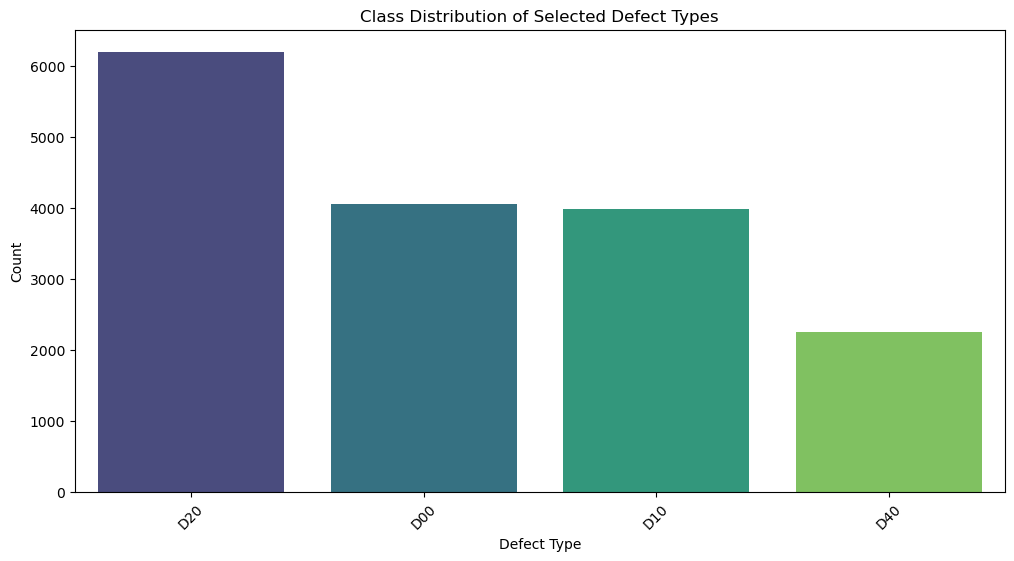

/Users/lakshay/anaconda3/envs/Backup_Class/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lakshay/anaconda3/envs/Backup_Class/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


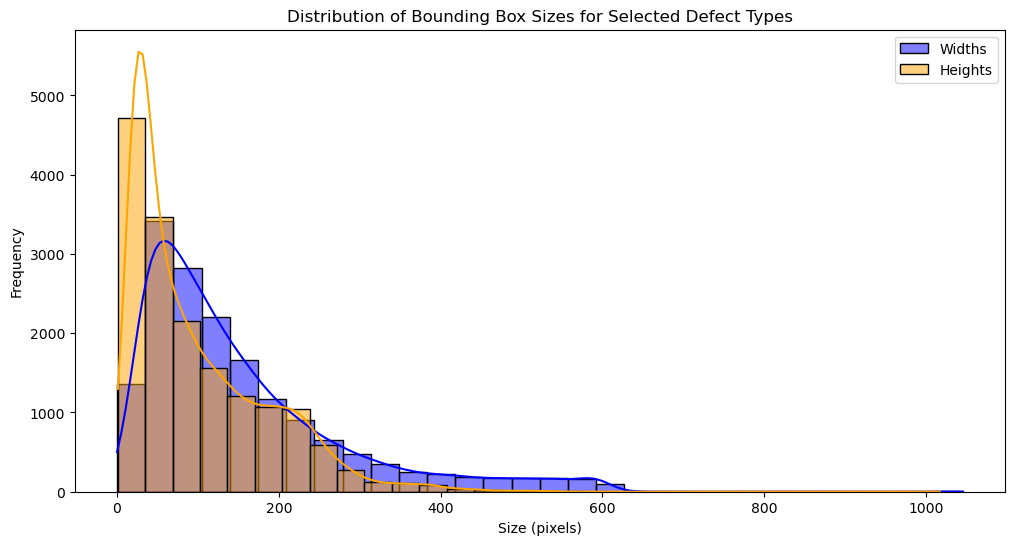

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
/Users/lakshay/anaconda3/envs/Backup_Class/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lakshay/anaconda3/envs/Backup_Class/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


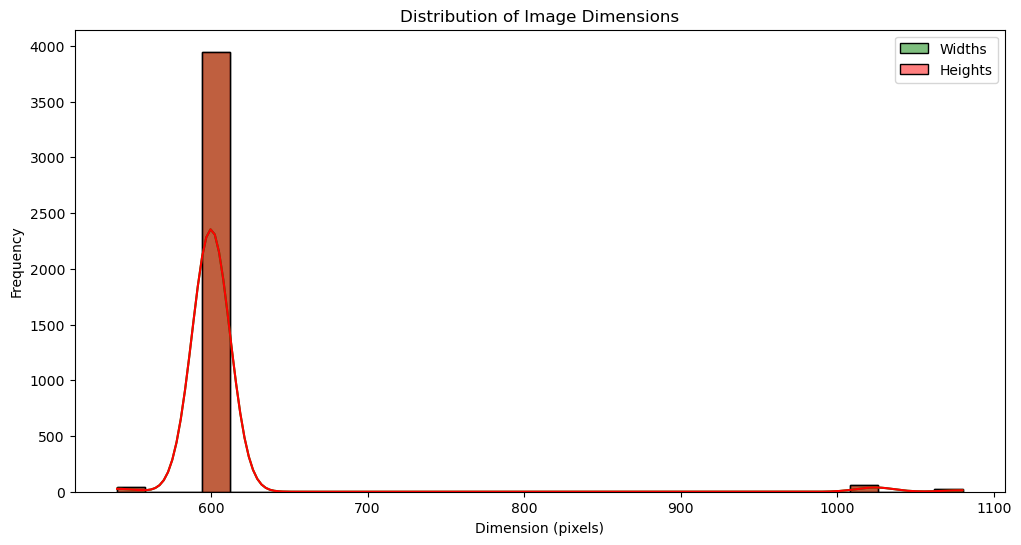

/Users/lakshay/anaconda3/envs/Backup_Class/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


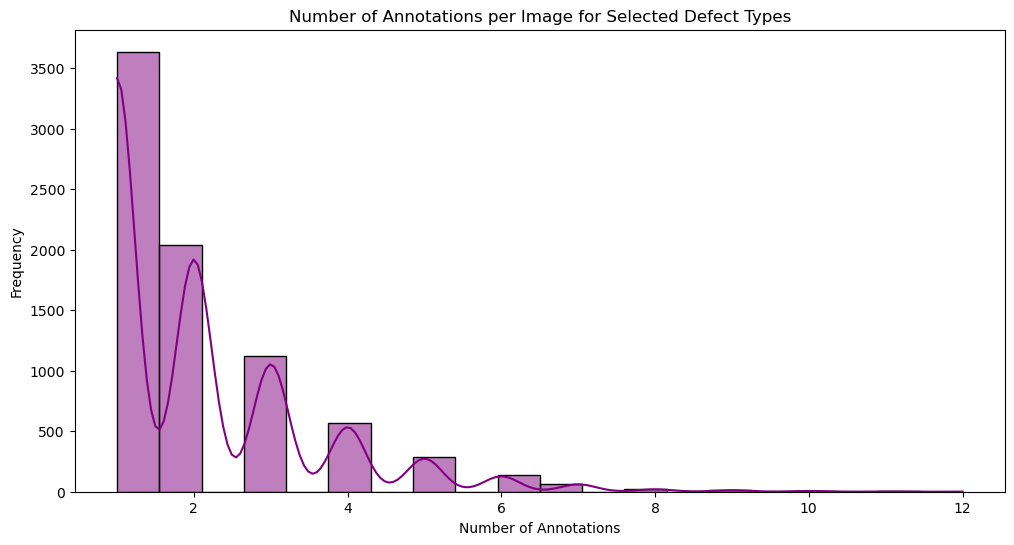

error: OpenCV(4.9.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import xml.etree.ElementTree as ET
import glob

# Define functions for reading and parsing XML, and drawing bounding boxes
def read_and_parse_xml(xml_file_path):
    """Reads and parses an XML file."""
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    return root

def encoded_obj_annotations(annotations):
    """Encodes object annotations."""
    objects_names = []
    for obj in annotations.findall('object'):
        label_code = obj.find('name').text
        objects_names.append(label_code)
    return objects_names

def process_annotation_file(xml_file_path):
    """Processes a single annotation file."""
    annotations = read_and_parse_xml(xml_file_path)
    objects_names = encoded_obj_annotations(annotations)
    return xml_file_path, objects_names

def process_all_annotations(xml_files):
    """Processes all annotation files in parallel and shows progress."""
    results = []
    with ThreadPoolExecutor() as executor:
        future_to_xml = {executor.submit(process_annotation_file, xml_file): xml_file for xml_file in xml_files}
        for future in tqdm(as_completed(future_to_xml), total=len(future_to_xml), desc="Processing files"):
            xml_file = future_to_xml[future]
            try:
                xml_file_path, objects_names = future.result()
                results.append((xml_file_path, objects_names))
            except Exception as exc:
                print(f"{xml_file} generated an exception: {exc}")
    return results

# Assuming you have already defined data paths and loaded image_list and annot_list
# Sample paths (replace with actual paths)
data_root_dir = "../data-collections/"
nationality = "Japan"
mode = "Train"
image_destination_path = os.path.join(data_root_dir, nationality, mode, "images")
annot_destination_path = os.path.join(data_root_dir, nationality, mode, "annotations/xmls")

# Get list of image and annotation files
image_list = glob.glob(image_destination_path+"/*.jpg")
annot_list = glob.glob(annot_destination_path+"/*.xml")

# Process all annotations
results = process_all_annotations(annot_list)

# Create DataFrame
df = pd.DataFrame(results, columns=['xml_file_path', 'objects'])

# Print columns to verify
print(df.columns)

# Create columns for each label with binary encoding
label_map = {
    "D00": "Wheel mark part",
    "D10": "Equal interval",
    "D20": "Partial pavement",
    "D40": "Rutting, bump, pothole, separation"
}

for label in label_map.keys():
    df[label] = df['objects'].apply(lambda x: x.count(label))

# Filter the dataset to include only specific labels
include_labels = {"D00", "D10", "D20", "D40"}
df_filtered = df[df["objects"].apply(lambda x: bool(include_labels.intersection(set(x))))]

# 1. Class Distribution
def plot_class_distribution(df, label_map):
    class_counts = df[label_map.keys()].sum().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
    plt.title("Class Distribution of Selected Defect Types")
    plt.xlabel("Defect Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(df_filtered, label_map)

# 2. Bounding Box Analysis
def get_bounding_box_sizes(annotations):
    sizes = []
    for obj in annotations.findall('object'):
        label = obj.find('name').text
        if label in include_labels:
            bndbox = obj.find('bndbox')
            width = int(bndbox.find('xmax').text) - int(bndbox.find('xmin').text)
            height = int(bndbox.find('ymax').text) - int(bndbox.find('ymin').text)
            sizes.append((width, height))
    return sizes

all_sizes = []
for xml_file in annot_list:
    annotations = read_and_parse_xml(xml_file)
    all_sizes.extend(get_bounding_box_sizes(annotations))

box_widths, box_heights = zip(*all_sizes)
plt.figure(figsize=(12, 6))
sns.histplot(box_widths, bins=30, kde=True, color='blue', label='Widths')
sns.histplot(box_heights, bins=30, kde=True, color='orange', label='Heights')
plt.title("Distribution of Bounding Box Sizes for Selected Defect Types")
plt.xlabel("Size (pixels)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 3. Image Dimension Analysis
image_dims = []
for img_file in image_list:
    image = cv2.imread(img_file)
    if image is not None:
        h, w, _ = image.shape
        image_dims.append((w, h))

img_widths, img_heights = zip(*image_dims)
plt.figure(figsize=(12, 6))
sns.histplot(img_widths, bins=30, kde=True, color='green', label='Widths')
sns.histplot(img_heights, bins=30, kde=True, color='red', label='Heights')
plt.title("Distribution of Image Dimensions")
plt.xlabel("Dimension (pixels)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 4. Annotation Density
annotation_counts = df_filtered[label_map.keys()].sum(axis=1)
plt.figure(figsize=(12, 6))
sns.histplot(annotation_counts, bins=20, kde=True, color='purple')
plt.title("Number of Annotations per Image for Selected Defect Types")
plt.xlabel("Number of Annotations")
plt.ylabel("Frequency")
plt.show()

# 5. Visualize Samples with Annotations
def draw_bounding_boxes(image_path, annotations):
    """Draws bounding boxes on the image."""
    image = cv2.imread(image_path)
    for (label, xmin, ymin, xmax, ymax) in annotations:
        if label in include_labels:
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
            cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

sample_indices = np.random.choice(len(image_list), 5, replace=False)
for idx in sample_indices:
    xml_file = annot_list[idx]
    img_file = image_list[idx]
    annotations = read_and_parse_xml(xml_file)
    objects = []
    for obj in annotations.findall('object'):
        label = obj.find('name').text
        if label in include_labels:
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            objects.append((label, xmin, ymin, xmax, ymax))
    image = draw_bounding_boxes(img_file, objects)
    
    if image is not None:
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
        plt.show()


Processing files: 100%|██████████| 10506/10506 [00:04<00:00, 2332.99it/s]


Index(['xml_file_path', 'objects'], dtype='object')


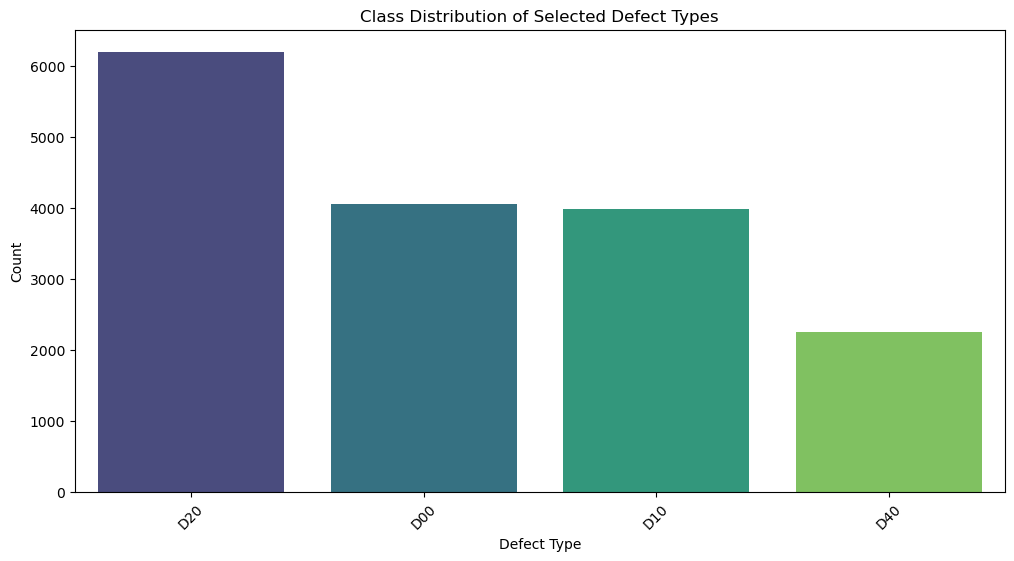

/Users/lakshay/anaconda3/envs/Backup_Class/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lakshay/anaconda3/envs/Backup_Class/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


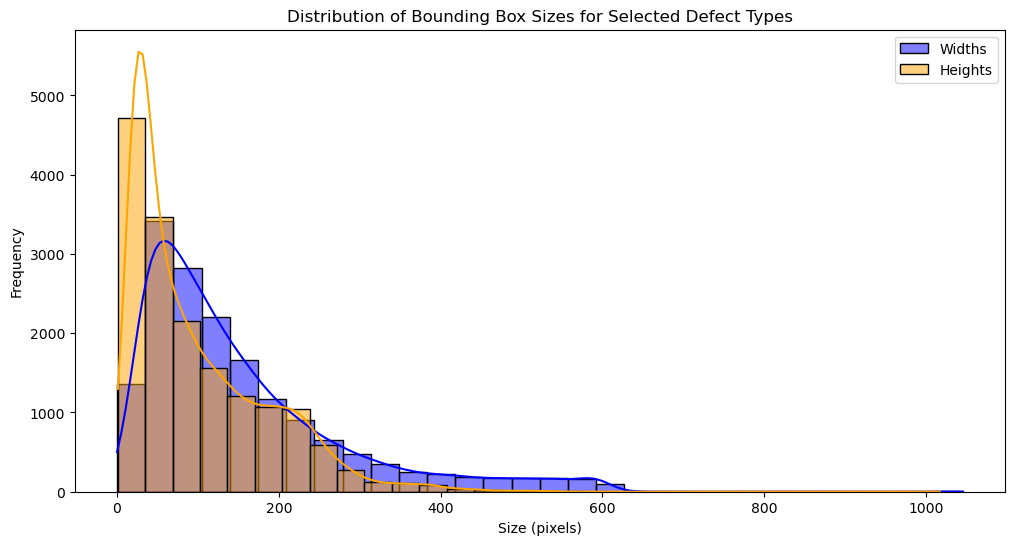

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
/Users/lakshay/anaconda3/envs/Backup_Class/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lakshay/anaconda3/envs/Backup_Class/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


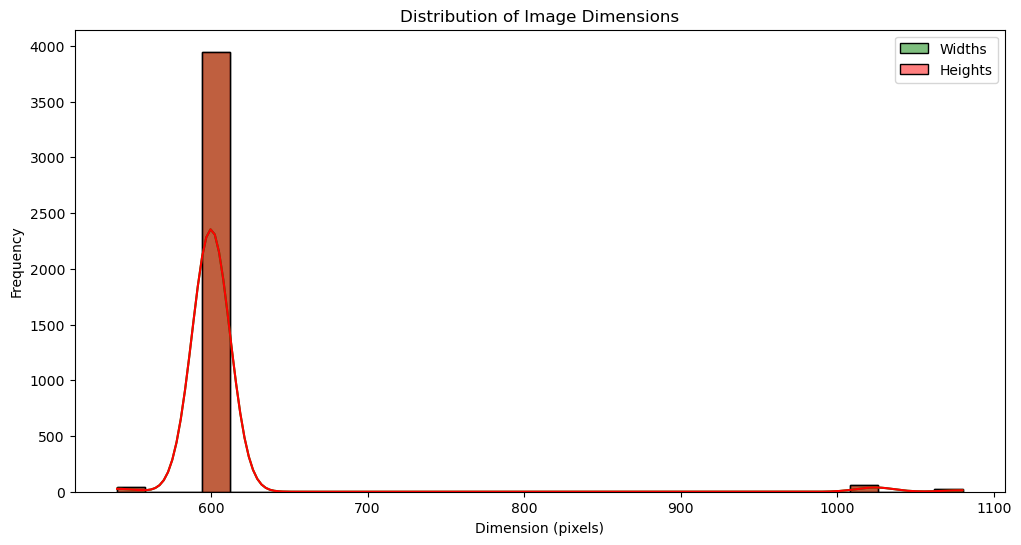

/Users/lakshay/anaconda3/envs/Backup_Class/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


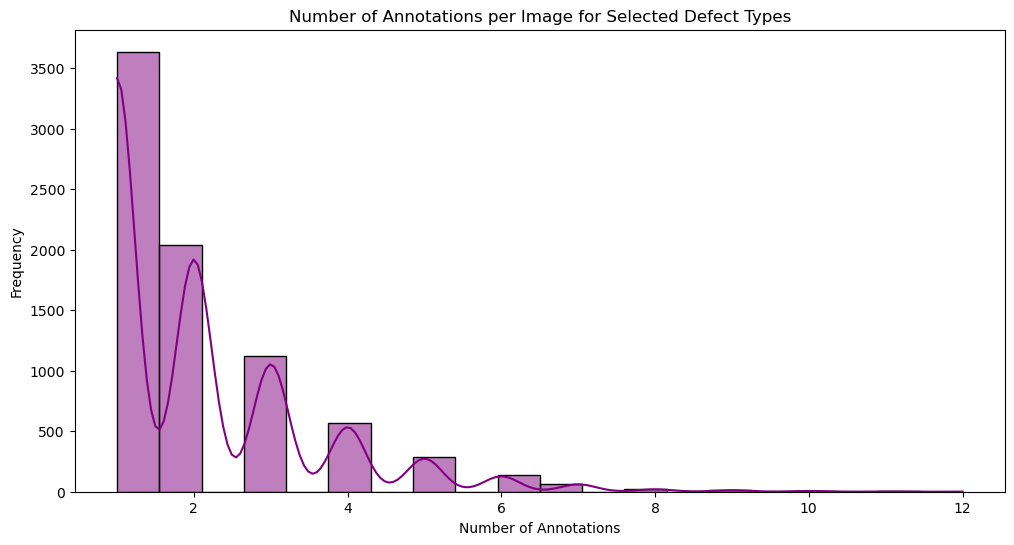

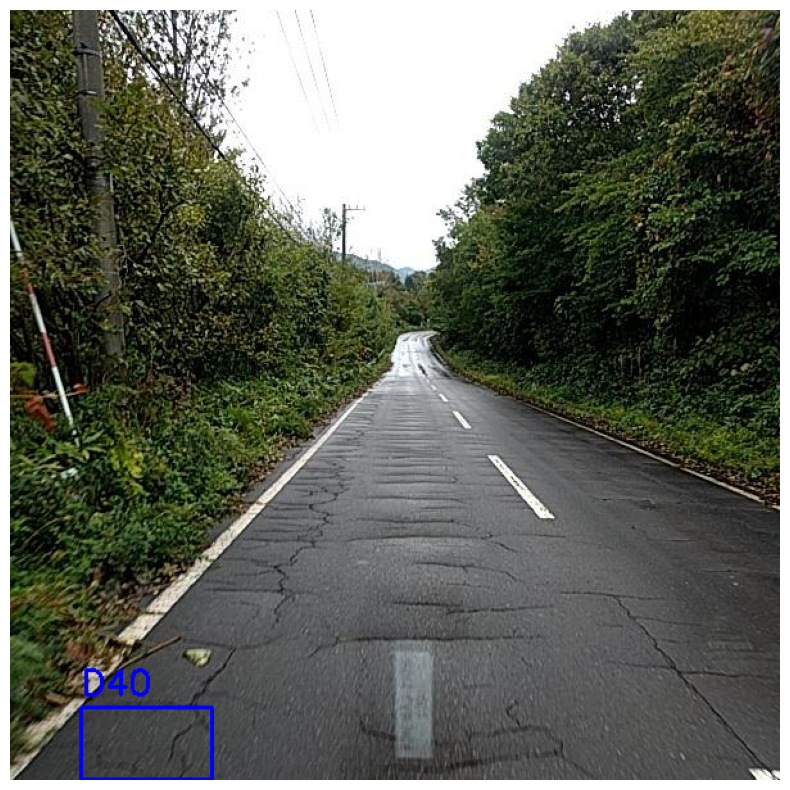

Error: Unable to load image at ../data-collections/Japan/Train/images/Japan_011255.jpg
Error: Unable to load image at ../data-collections/Japan/Train/images/Japan_003140.jpg
Error: Unable to load image at ../data-collections/Japan/Train/images/Japan_003795.jpg


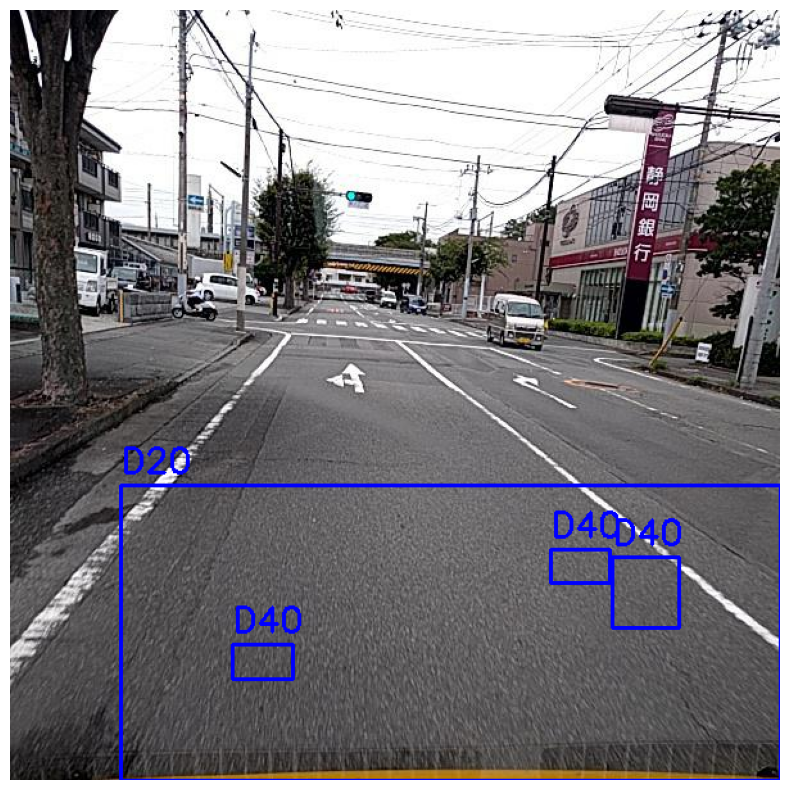

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import xml.etree.ElementTree as ET
import glob

# Define functions for reading and parsing XML, and drawing bounding boxes
def read_and_parse_xml(xml_file_path):
    """Reads and parses an XML file."""
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    return root

def encoded_obj_annotations(annotations):
    """Encodes object annotations."""
    objects_names = []
    for obj in annotations.findall('object'):
        label_code = obj.find('name').text
        objects_names.append(label_code)
    return objects_names

def process_annotation_file(xml_file_path):
    """Processes a single annotation file."""
    annotations = read_and_parse_xml(xml_file_path)
    objects_names = encoded_obj_annotations(annotations)
    return xml_file_path, objects_names

def process_all_annotations(xml_files):
    """Processes all annotation files in parallel and shows progress."""
    results = []
    with ThreadPoolExecutor() as executor:
        future_to_xml = {executor.submit(process_annotation_file, xml_file): xml_file for xml_file in xml_files}
        for future in tqdm(as_completed(future_to_xml), total=len(future_to_xml), desc="Processing files"):
            xml_file = future_to_xml[future]
            try:
                xml_file_path, objects_names = future.result()
                results.append((xml_file_path, objects_names))
            except Exception as exc:
                print(f"{xml_file} generated an exception: {exc}")
    return results

# Assuming you have already defined data paths and loaded image_list and annot_list
# Sample paths (replace with actual paths)
data_root_dir = "../data-collections/"
nationality = "Japan"
mode = "Train"
image_destination_path = os.path.join(data_root_dir, nationality, mode, "images")
annot_destination_path = os.path.join(data_root_dir, nationality, mode, "annotations/xmls")

# Get list of image and annotation files
image_list = glob.glob(image_destination_path+"/*.jpg")
annot_list = glob.glob(annot_destination_path+"/*.xml")

# Process all annotations
results = process_all_annotations(annot_list)

# Create DataFrame
df = pd.DataFrame(results, columns=['xml_file_path', 'objects'])

# Print columns to verify
print(df.columns)

# Create columns for each label with binary encoding
label_map = {
    "D00": "Wheel mark part",
    "D10": "Equal interval",
    "D20": "Partial pavement",
    "D40": "Rutting, bump, pothole, separation"
}

for label in label_map.keys():
    df[label] = df['objects'].apply(lambda x: x.count(label))

# Filter the dataset to include only specific labels
include_labels = {"D00", "D10", "D20", "D40"}
df_filtered = df[df["objects"].apply(lambda x: bool(include_labels.intersection(set(x))))]

# 1. Class Distribution
def plot_class_distribution(df, label_map):
    class_counts = df[label_map.keys()].sum().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
    plt.title("Class Distribution of Selected Defect Types")
    plt.xlabel("Defect Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(df_filtered, label_map)

# 2. Bounding Box Analysis
def get_bounding_box_sizes(annotations):
    sizes = []
    for obj in annotations.findall('object'):
        label = obj.find('name').text
        if label in include_labels:
            bndbox = obj.find('bndbox')
            width = int(bndbox.find('xmax').text) - int(bndbox.find('xmin').text)
            height = int(bndbox.find('ymax').text) - int(bndbox.find('ymin').text)
            sizes.append((width, height))
    return sizes

all_sizes = []
for xml_file in annot_list:
    annotations = read_and_parse_xml(xml_file)
    all_sizes.extend(get_bounding_box_sizes(annotations))

box_widths, box_heights = zip(*all_sizes)
plt.figure(figsize=(12, 6))
sns.histplot(box_widths, bins=30, kde=True, color='blue', label='Widths')
sns.histplot(box_heights, bins=30, kde=True, color='orange', label='Heights')
plt.title("Distribution of Bounding Box Sizes for Selected Defect Types")
plt.xlabel("Size (pixels)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 3. Image Dimension Analysis
image_dims = []
for img_file in image_list:
    image = cv2.imread(img_file)
    if image is not None:
        h, w, _ = image.shape
        image_dims.append((w, h))

img_widths, img_heights = zip(*image_dims)
plt.figure(figsize=(12, 6))
sns.histplot(img_widths, bins=30, kde=True, color='green', label='Widths')
sns.histplot(img_heights, bins=30, kde=True, color='red', label='Heights')
plt.title("Distribution of Image Dimensions")
plt.xlabel("Dimension (pixels)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 4. Annotation Density
annotation_counts = df_filtered[label_map.keys()].sum(axis=1)
plt.figure(figsize=(12, 6))
sns.histplot(annotation_counts, bins=20, kde=True, color='purple')
plt.title("Number of Annotations per Image for Selected Defect Types")
plt.xlabel("Number of Annotations")
plt.ylabel("Frequency")
plt.show()

# 5. Visualize Samples with Annotations
def draw_bounding_boxes(image_path, annotations):
    """Draws bounding boxes on the image."""
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return None
    for (label, xmin, ymin, xmax, ymax) in annotations:
        if label in include_labels:
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
            cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

sample_indices = np.random.choice(len(image_list), 5, replace=False)
for idx in sample_indices:
    xml_file = annot_list[idx]
    img_file = image_list[idx]
    annotations = read_and_parse_xml(xml_file)
    objects = []
    for obj in annotations.findall('object'):
        label = obj.find('name').text
        if label in include_labels:
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            objects.append((label, xmin, ymin, xmax, ymax))
    image = draw_bounding_boxes(img_file, objects)
    
    if image is not None:
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
        plt.show()
